<a href="https://colab.research.google.com/github/Luizaxx/teste-lab-livre/blob/main/teste_lab_livre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q requests pandas sqlalchemy matplotlib seaborn

In [2]:
import requests
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import json
import os
from google.colab import files

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
sns.set_style("whitegrid")


In [3]:
BASE_URL = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"


params = {
    "uf": "DF", # da forma que pede o teste
    "page": 0,
    "size": 1000
}

import time
from requests.exceptions import RequestException

def fetch_all(base_url, params, timeout=30, retries=5, delay=5):
    all_items = []
    p = params.copy()
    for attempt in range(retries):
        try:
            while True:
                print(f"Request page {p.get('page',0)} ...", end=" ")
                resp = requests.get(base_url, params=p, timeout=timeout)
                resp.raise_for_status()
                data = resp.json()

                if isinstance(data, dict) and 'content' in data:
                    items = data['content']
                    all_items.extend(items)
                    print(f"obtidos {len(items)}")

                    if data.get('last') or len(items) == 0:
                        break
                    p['page'] = p.get('page', 0) + 1
                elif isinstance(data, list):
                    all_items.extend(data)
                    print(f"obtidos {len(data)} (lista)")
                    break
                else:
                    if 'results' in data:
                        all_items.extend(data['results'])
                        break
                    else:
                        all_items.append(data)
                        break
            return all_items # Return data on success
        except RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay * (2 ** attempt)) # Exponential backoff
            else:
                raise # Re-raise the exception after all retries

    return all_items # Should not be reached if retries are exhausted


raw = fetch_all(BASE_URL, params)
print("Total registros:", len(raw))

Request page 0 ... Attempt 1 failed: HTTPSConnectionPool(host='api.obrasgov.gestao.gov.br', port=443): Read timed out. (read timeout=30)
Request page 0 ... obtidos 10
Total registros: 10


In [4]:
if len(raw) == 0:
    df = pd.DataFrame()
else:
    df = pd.json_normalize(raw)

print("Dimensões:", df.shape)
display(df.head(5))
display(df.dtypes)
display(df.isna().mean().sort_values(ascending=False).head(20))


Dimensões: (10, 31)


,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
0,50379.53-54,DL - 304/2024 - Contratação de instituição par...,None,None,Contratação de instituição para execução de se...,Ampliação da capacidade de trafego visando a m...,Projetos Básicos e Executivos de Engenharia,2024-12-20,2027-12-05,None,None,2024-12-20,Construção,Outros,CONSULTORIA,Cadastrada,None,DF,None,None,None,None,False,2024-12-20,[],[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
1,42724.53-27,Escola Classe Crixá São Sebastião,None,None,"Construção de Escola em Tempo Integral, Escola...",A construção da nova escola beneficiará 977 es...,"Construção de Escola em Tempo Integral, Escola...",2024-09-02,2028-09-02,None,None,2024-08-30,Construção,Obra,None,Cancelada,None,DF,30,A população diretamente beneficiada pela EC Cr...,385,None,False,2025-09-05,[],[{'nome': 'SECRETARIA DE ESTADO DE EDUCACAO DO...,[{'nome': 'FUNDO NACIONAL DE DESENVOLVIMENTO D...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 46, 'descricao': 'Educação', 'idEixo':...","[{'id': 84, 'descricao': 'Educação', 'idTipo':...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
2,19970.53-78,Reajuste do Contrato 45/2021 - Contrução do Ce...,70.602-600,"SAIS Área Especial 3, Setor Policial Sul",Reajuste do Contrato 45/2021 - Construção do C...,Contribuir para a melhor formação dos bombeiro...,Construção de um novo centro de formação e de ...,2021-09-14,2024-08-28,None,None,2023-02-06,Construção,Obra,None,Cadastrada,None,DF,None,None,None,None,False,2023-02-06,[],[{'nome': 'CORPO DE BOMBEIROS MILITAR DO DISTR...,[{'nome': 'CORPO DE BOMBEIROS MILITAR DO DISTR...,"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 1, 'descricao': 'Segurança Pública', '...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
3,24797.53-15,Implantação de Passarelas nas Estradas Parque ...,None,None,Implantação de passarelas de estrutura mista n...,"Pedestres, no geral, demanda das ocupações lin...",Implantação de passarelas de estrutura mista n...,2023-08-30,2028-08-30,None,None,2023-08-28,Construção,Obra,None,Cadastrada,None,DF,None,"Pedestres que moram nas regiões de Planaltina,...",None,None,False,2023-08-28,[],[{'nome': 'DEPARTAMENTO DE ESTRADAS DE RODAGEM...,"[{'nome': 'MINISTÉRIO DAS CIDADES', 'codigo': ...","[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 24, 'descricao': 'Infraestrutura Urban...","[{'id': 57, 'descricao': 'Obra de Arte Especia...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
4,24822.53-70,"obra de construção da Cabine de Medição, loca...",None,None,"obra de construção da Cabine de Medição, loca...",A demanda de carga elétrica do Campus Darcy Ri...,A demanda de carga elétrica do Campus Darcy Ri...,2023-09-14,2024-03-14,None,None,2023-08-29,Construção,Obra,None,Cadastrada,None,DF,None,None,None,None,False,2023-08-29,[],"[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'id': 3, 'descricao': 'Econômico'}, {'id': 3...","[{'id': 31, 'descricao': 'Energia', 'idEixo': ...","[{'id': 95, 'descricao': 'Subestação', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


,0
idUnico,object
nome,object
cep,object
endereco,object
descricao,object
funcaoSocial,object
metaGlobal,object
dataInicialPrevista,object
dataFinalPrevista,object
dataInicialEfetiva,object


,0
dataFinalEfetiva,1.0
dataInicialEfetiva,1.0
observacoesPertinentes,1.0
qdtEmpregosGerados,0.9
populacaoBeneficiada,0.9
descPlanoNacionalPoliticaVinculado,0.8
descPopulacaoBeneficiada,0.8
naturezaOutras,0.6
endereco,0.4
cep,0.4


In [5]:
def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_").replace(".", "").replace("-", "_") for c in df.columns]
    return df

df = normalize_cols(df)

id_candidate = None
for c in df.columns:
    if c in ('id', 'codigo', 'codigo_projeto') or 'id' in c:
        id_candidate = c
        break

if id_candidate:
    df = df.drop_duplicates(subset=[id_candidate])
else:
    df = df.drop_duplicates()


for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

display(df.shape)
display(df.head(3))


(10, 31)

,idunico,nome,cep,endereco,descricao,funcaosocial,metaglobal,datainicialprevista,datafinalprevista,datainicialefetiva,datafinalefetiva,datacadastro,especie,natureza,naturezaoutras,situacao,descplanonacionalpoliticavinculado,uf,qdtempregosgerados,descpopulacaobeneficiada,populacaobeneficiada,observacoespertinentes,ismodeladaporbim,datasituacao,tomadores,executores,repassadores,eixos,tipos,subtipos,fontesderecurso
0,50379.53-54,DL - 304/2024 - Contratação de instituição par...,None,None,Contratação de instituição para execução de se...,Ampliação da capacidade de trafego visando a m...,Projetos Básicos e Executivos de Engenharia,2024-12-20,2027-12-05,None,None,2024-12-20,Construção,Outros,CONSULTORIA,Cadastrada,None,DF,None,None,None,None,False,2024-12-20,[],[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
1,42724.53-27,Escola Classe Crixá São Sebastião,None,None,"Construção de Escola em Tempo Integral, Escola...",A construção da nova escola beneficiará 977 es...,"Construção de Escola em Tempo Integral, Escola...",2024-09-02,2028-09-02,None,None,2024-08-30,Construção,Obra,None,Cancelada,None,DF,30,A população diretamente beneficiada pela EC Cr...,385,None,False,2025-09-05,[],[{'nome': 'SECRETARIA DE ESTADO DE EDUCACAO DO...,[{'nome': 'FUNDO NACIONAL DE DESENVOLVIMENTO D...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 46, 'descricao': 'Educação', 'idEixo':...","[{'id': 84, 'descricao': 'Educação', 'idTipo':...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
2,19970.53-78,Reajuste do Contrato 45/2021 - Contrução do Ce...,70.602-600,"SAIS Área Especial 3, Setor Policial Sul",Reajuste do Contrato 45/2021 - Construção do C...,Contribuir para a melhor formação dos bombeiro...,Construção de um novo centro de formação e de ...,2021-09-14,2024-08-28,None,None,2023-02-06,Construção,Obra,None,Cadastrada,None,DF,None,None,None,None,False,2023-02-06,[],[{'nome': 'CORPO DE BOMBEIROS MILITAR DO DISTR...,[{'nome': 'CORPO DE BOMBEIROS MILITAR DO DISTR...,"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 1, 'descricao': 'Segurança Pública', '...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


In [6]:

print("Antes da normalização:")
print(list(df.columns))


df_normalizado = df.copy()
df_normalizado.columns = [c.strip().lower().replace(" ", "_").replace(".", "").replace("-", "_") for c in df_normalizado.columns]

print("\nDepois da normalização:")
print(list(df_normalizado.columns))

## as colunas ja aparentavam estar normalizadas


Antes da normalização:
['idunico', 'nome', 'cep', 'endereco', 'descricao', 'funcaosocial', 'metaglobal', 'datainicialprevista', 'datafinalprevista', 'datainicialefetiva', 'datafinalefetiva', 'datacadastro', 'especie', 'natureza', 'naturezaoutras', 'situacao', 'descplanonacionalpoliticavinculado', 'uf', 'qdtempregosgerados', 'descpopulacaobeneficiada', 'populacaobeneficiada', 'observacoespertinentes', 'ismodeladaporbim', 'datasituacao', 'tomadores', 'executores', 'repassadores', 'eixos', 'tipos', 'subtipos', 'fontesderecurso']

Depois da normalização:
['idunico', 'nome', 'cep', 'endereco', 'descricao', 'funcaosocial', 'metaglobal', 'datainicialprevista', 'datafinalprevista', 'datainicialefetiva', 'datafinalefetiva', 'datacadastro', 'especie', 'natureza', 'naturezaoutras', 'situacao', 'descplanonacionalpoliticavinculado', 'uf', 'qdtempregosgerados', 'descpopulacaobeneficiada', 'populacaobeneficiada', 'observacoespertinentes', 'ismodeladaporbim', 'datasituacao', 'tomadores', 'executores',

In [7]:

date_cols = [c for c in df.columns if 'data' in c or c.startswith('dt') or 'date' in c or 'mes' in c]
print("Possíveis datas:", date_cols)
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')


for c in df.columns:
    if df[c].dtype == object:
        conv = pd.to_numeric(df[c].str.replace(',','.')\
                            .str.replace(r'[^\d\.-]', '' , regex=True), errors='coerce')
        if conv.notna().mean() > 0.8:
            df[c] = conv

display(df.dtypes)


Possíveis datas: ['datainicialprevista', 'datafinalprevista', 'datainicialefetiva', 'datafinalefetiva', 'datacadastro', 'datasituacao']


/tmp/ipython-input-2981394661.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2981394661.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')


,0
idunico,object
nome,object
cep,object
endereco,object
descricao,object
funcaosocial,object
metaglobal,object
datainicialprevista,datetime64[ns]
datafinalprevista,datetime64[ns]
datainicialefetiva,datetime64[ns]


In [8]:
def missing_report(df):
    rep = pd.DataFrame({
        "coluna": df.columns,
        "tipo": df.dtypes.astype(str),
        "nulos": df.isna().sum(),
        "pct_nulos": df.isna().mean()
    }).sort_values("pct_nulos", ascending=False)
    return rep

rep = missing_report(df)
display(rep.head(40))
for c in df.select_dtypes(include=['object']).columns:
    if df[c].isna().mean() > 0 and df[c].nunique() < 200:
        df[c] = df[c].fillna("Desconhecido")


,coluna,tipo,nulos,pct_nulos
datafinalefetiva,datafinalefetiva,datetime64[ns],10,1.0
datainicialefetiva,datainicialefetiva,datetime64[ns],10,1.0
eixos,eixos,float64,1,0.1
repassadores,repassadores,float64,1,0.1
descricao,descricao,object,0,0.0
endereco,endereco,object,0,0.0
idunico,idunico,object,0,0.0
metaglobal,metaglobal,object,0,0.0
funcaosocial,funcaosocial,object,0,0.0
datafinalprevista,datafinalprevista,datetime64[ns],0,0.0


In [10]:
# Imports mínimos
from sqlalchemy import Table, Column, MetaData, String, Float, DateTime, Text, create_engine, text, Integer
import pandas as pd
from google.colab import files


db_path = "obrasgov_df.db"
engine = create_engine(f"sqlite:///{db_path}", echo=False)
metadata = MetaData()

# Reflect the existing table to get its structure
# If the table doesn't exist, this will raise an exception which we handle by creating a new table
try:
    projetos = Table('projetos_df', metadata, autoload_with=engine)
except Exception as e:
    print(f"Table 'projetos_df' not found or reflection failed: {e}")
    print("Creating a new table with all columns from the DataFrame.")

    # Define columns based on the DataFrame's columns and dtypes
    cols_to_include = []
    for col_name, dtype in df.dtypes.items():
        if col_name == 'idunico':
            cols_to_include.append(Column(col_name, String, primary_key=True))
        elif 'datetime' in str(dtype):
            cols_to_include.append(Column(col_name, DateTime))
        elif 'float' in str(dtype):
            cols_to_include.append(Column(col_name, Float))
        elif 'int' in str(dtype):
             cols_to_include.append(Column(col_name, Integer))
        elif 'object' in str(dtype):
            # Attempt to use Text for potentially long strings, otherwise String
            max_len = df[col_name].astype(str).str.len().max()
            if max_len is None or max_len > 255: # Heuristic for potentially long text
                 cols_to_include.append(Column(col_name, Text))
            else:
                 cols_to_include.append(Column(col_name, String))
        else:
             # Default to String for any other types
             cols_to_include.append(Column(col_name, String))

    projetos = Table('projetos_df', metadata, *cols_to_include)

    # Drop the existing table if it exists and recreate it with the new definition
    metadata.drop_all(engine)
    metadata.create_all(engine)


# Ensure all columns in the DataFrame exist in the table before inserting
existing_cols = [c.name for c in projetos.columns]
for c in df.columns:
    if c not in existing_cols:
        print(f"Warning: Column '{c}' from DataFrame not found in table 'projetos_df'. Skipping insertion for this column.")
        # You might want to handle this case differently, e.g., add the column to the table

# Select only the columns that exist in both the DataFrame and the table for insertion
cols_to_insert = [c for c in df.columns if c in existing_cols]
df_to_insert = df[cols_to_insert]

# Convert datetime columns to a format compatible with SQLite
dt_cols = [c.name for c in projetos.columns if isinstance(c.type, DateTime)]
for c in dt_cols:
    if c in df_to_insert.columns:
        df_to_insert[c] = pd.to_datetime(df_to_insert[c], errors='coerce')


df_to_insert.to_sql('projetos_df', con=engine, if_exists='replace', index=False, method='multi')


with engine.connect() as conn:
    total = conn.execute(text("SELECT COUNT(1) FROM projetos_df")).fetchone()[0]
print("Total registros na tabela projetos_df:", total)


sample = pd.read_sql_query("SELECT * FROM projetos_df LIMIT 5", engine)
display(sample)


# Download do arquivo .db
#files.download(db_path)

Total registros na tabela projetos_df: 10


/tmp/ipython-input-2183000418.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_insert[c] = pd.to_datetime(df_to_insert[c], errors='coerce')
/tmp/ipython-input-2183000418.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_insert[c] = pd.to_datetime(df_to_insert[c], errors='coerce')
/tmp/ipython-input-2183000418.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,idunico,nome,cep,endereco,descricao,metaglobal,datainicialprevista,datafinalprevista,datainicialefetiva,datafinalefetiva,datacadastro,uf,repassadores,eixos
0,50379.53-54,DL - 304/2024 - Contratação de instituição par...,None,None,Contratação de instituição para execução de se...,Projetos Básicos e Executivos de Engenharia,2024-12-20 00:00:00.000000,2027-12-05 00:00:00.000000,None,None,2024-12-20 00:00:00.000000,DF,NaN,3.0
1,42724.53-27,Escola Classe Crixá São Sebastião,None,None,"Construção de Escola em Tempo Integral, Escola...","Construção de Escola em Tempo Integral, Escola...",2024-09-02 00:00:00.000000,2028-09-02 00:00:00.000000,None,None,2024-08-30 00:00:00.000000,DF,0.253000,4.0
2,19970.53-78,Reajuste do Contrato 45/2021 - Contrução do Ce...,70.602-600,"SAIS Área Especial 3, Setor Policial Sul",Reajuste do Contrato 45/2021 - Construção do C...,Construção de um novo centro de formação e de ...,2021-09-14 00:00:00.000000,2024-08-28 00:00:00.000000,None,None,2023-02-06 00:00:00.000000,DF,0.897791,1.0
3,24797.53-15,Implantação de Passarelas nas Estradas Parque ...,None,None,Implantação de passarelas de estrutura mista n...,Implantação de passarelas de estrutura mista n...,2023-08-30 00:00:00.000000,2028-08-30 00:00:00.000000,None,None,2023-08-28 00:00:00.000000,DF,0.308798,3.0
4,24822.53-70,"obra de construção da Cabine de Medição, loca...",None,None,"obra de construção da Cabine de Medição, loca...",A demanda de carga elétrica do Campus Darcy Ri...,2023-09-14 00:00:00.000000,2024-03-14 00:00:00.000000,None,None,2023-08-29 00:00:00.000000,DF,0.262710,NaN


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
idunico,10,10,50379.53-54,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nome,10,8,202111-22-Ronald 1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cep,10,5,None,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
endereco,10,4,None,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
descricao,10,8,2021122-Ronald - Descrição do Projeto,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funcaosocial,10,8,2021122-Ronald - Descrição Funç]ap Social,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metaglobal,10,8,20211122-Ronald - Descrição Meta Global,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
datainicialprevista,10,NaN,NaN,NaN,2023-03-06 14:24:00,2021-09-14 00:00:00,2021-12-10 00:00:00,2023-08-15 12:00:00,2023-09-10 18:00:00,2024-12-20 00:00:00,NaN
datafinalprevista,5,NaN,NaN,NaN,2024-02-28 19:12:00,2021-10-12 00:00:00,2021-10-12 00:00:00,2021-10-12 00:00:00,2027-05-12 00:00:00,2028-02-09 00:00:00,NaN
datainicialefetiva,0,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN


,count
situacao,
Cadastrada,9
Cancelada,1


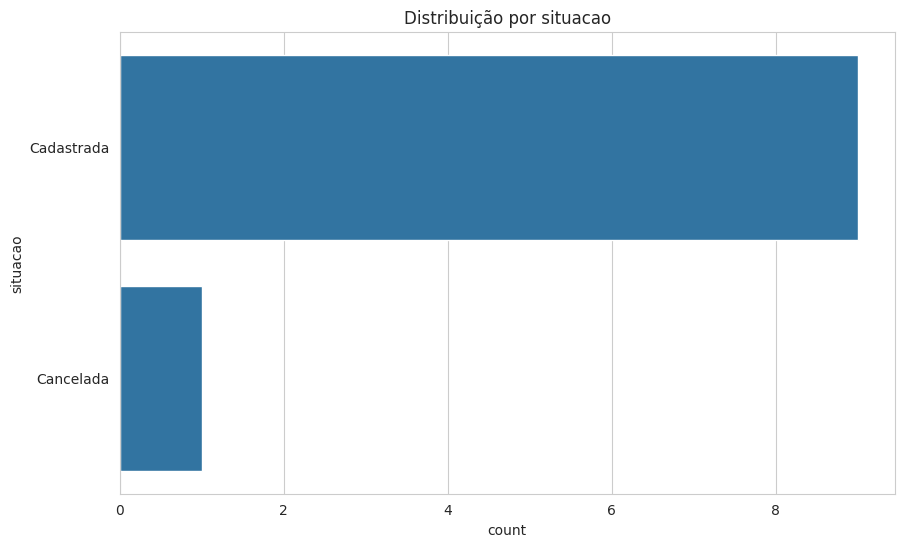

In [ ]:
display(df.describe(include='all').T)

status_cols = [c for c in df.columns if 'situ' in c or 'status' in c]
if status_cols:
    s = status_cols[0]
    display(df[s].value_counts().head(20))
    plt.figure(figsize=(10,6))
    sns.countplot(y=s, data=df, order=df[s].value_counts().index[:20])
    plt.title("Distribuição por " + s)
    plt.show()

money_cols = [c for c in df.columns if 'valor' in c or 'orcamento' in c or 'invest' in c]
if money_cols:
    m = money_cols[0]
    plt.figure(figsize=(8,5))
    sns.histplot(df[m].dropna(), kde=False)
    plt.title("Distribuição de " + m)
    plt.show()


In [ ]:
# municípios por UF, mas é só o DF
geo_cols = [c for c in df.columns if 'municip' in c or 'cidade' in c or c=='uf' or 'estado' in c]
if geo_cols:
    g = geo_cols[0]
    display(df[g].value_counts().head(15))


,count
uf,
DF,10


,count
ano_datainicialprevista,
2021,4
2023,4
2024,2


In [11]:
db_path = "obrasgov_df.db"
engine = create_engine(f"sqlite:///{db_path}", echo=False)

# Carregar os dados da tabela
df = pd.read_sql_query("SELECT * FROM projetos_df", engine)

# Salvar em CSV
csv_path = "projetos_df.csv"
df.to_csv(csv_path, index=False)

# Download do arquivo CSV
print(f"'{csv_path}' criado. Clique no link para baixar:")
files.download(csv_path)

'projetos_df.csv' criado. Clique no link para baixar:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

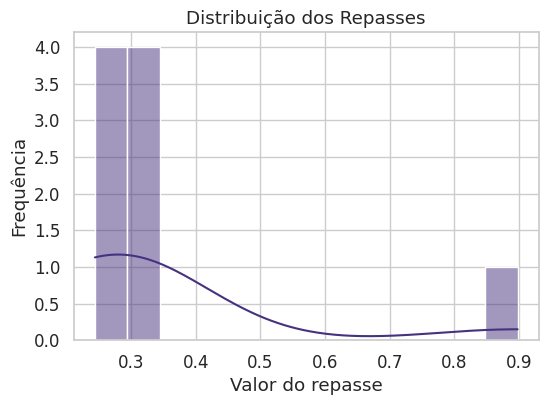

In [15]:

plt.figure(figsize=(6,4))
sns.histplot(df['repassadores'], kde=True)
plt.title("Distribuição dos Repasses")
plt.xlabel("Valor do repasse")
plt.ylabel("Frequência")
plt.show()

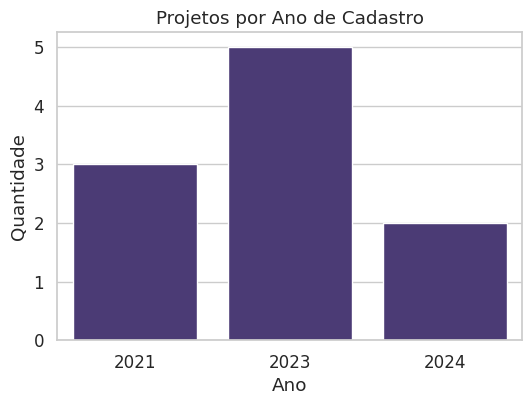

In [16]:
plt.figure(figsize=(6,4))
df['ano_cadastro'] = df['datacadastro'].dt.year
sns.countplot(x='ano_cadastro', data=df)
plt.title("Projetos por Ano de Cadastro")
plt.xlabel("Ano")
plt.ylabel("Quantidade")
plt.show()

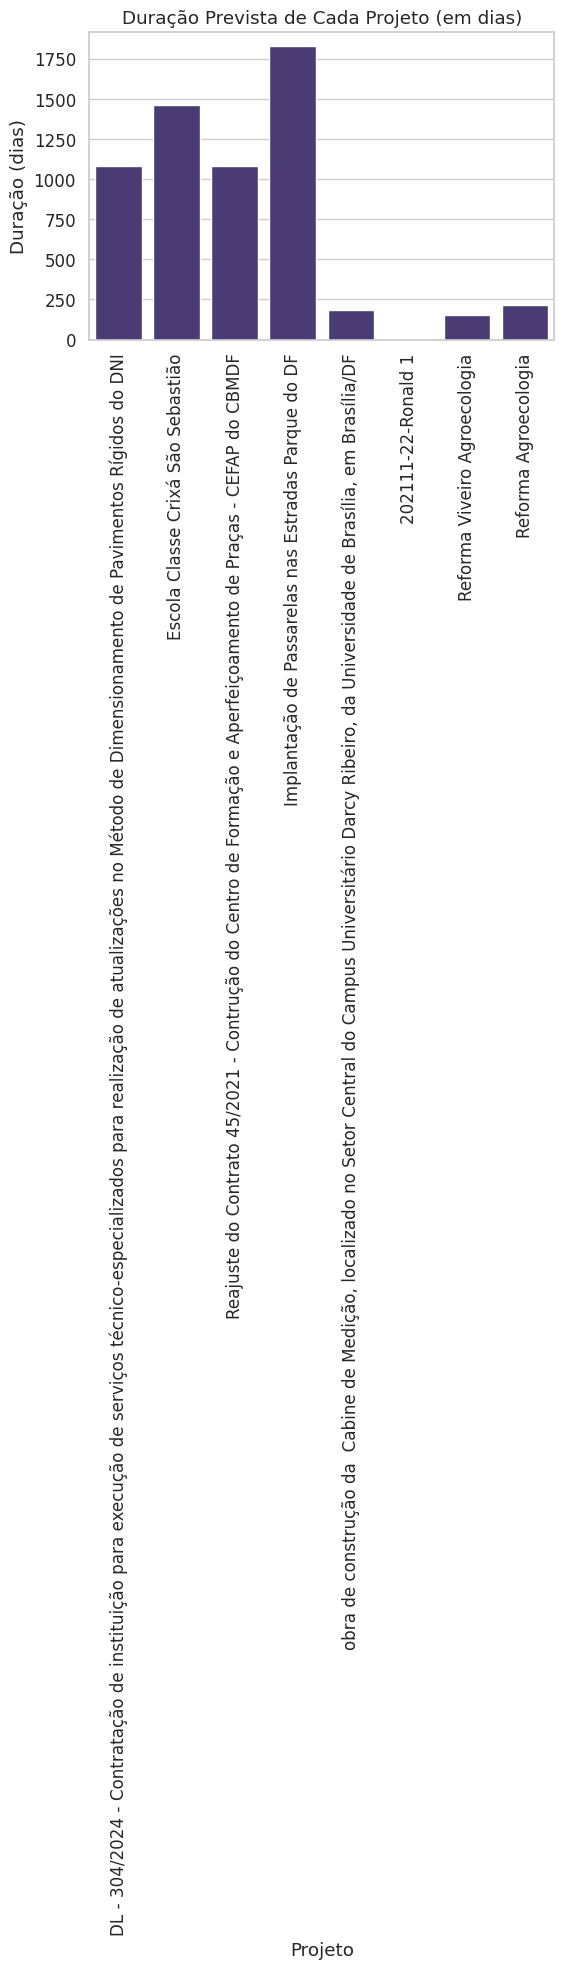

In [17]:
df['duracao_prevista_dias'] = (df['datafinalprevista'] - df['datainicialprevista']).dt.days
plt.figure(figsize=(6,4))
sns.barplot(x='nome', y='duracao_prevista_dias', data=df)
plt.xticks(rotation=90)
plt.title("Duração Prevista de Cada Projeto (em dias)")
plt.xlabel("Projeto")
plt.ylabel("Duração (dias)")
plt.show()

## Conclusões finais:
Atualmente trabalho com um pouco de análise de dados no estágio, contudo mas para anonimização de dados sensíveis e serialização de outros dados, na parte de plotar dados, usamos o python apenas para demandas internas e para dados abertos trabalho mais com ferramentas de bi como power bi e qlik sense, em banco de dados mexemos apenas com o oracle. Sobre o trabalho: achei interessante, nunca havia trabalhado com sqlite no notebook lm, então obtive dificuldades e obtive ajuda do gemini para conseguir (consertar) rodar o projeto, ademais, acredito que os gráficos são bons para análise apesar de simples e no dia a dia isso também é muito ais alinhado com o cliente.

Desde já agradeço!